In [39]:
import keras

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Load image data
imgdat_glass = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_glass.npy')
imgdat_paper = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_paper.npy')
imgdat_cardboard = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_cardboard.npy')
imgdat_plastic = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_plastic.npy')
imgdat_metal = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_metal.npy')
imgdat_trash = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_trash.npy')

# Make sure the data loaded correctly
print(imgdat_glass.shape)
print(imgdat_paper.shape)
print(imgdat_cardboard.shape)
print(imgdat_plastic.shape)
print(imgdat_metal.shape)
print(imgdat_trash.shape)

(501, 100, 100, 3)
(594, 100, 100, 3)
(403, 100, 100, 3)
(482, 100, 100, 3)
(410, 100, 100, 3)
(137, 100, 100, 3)


In [25]:
# Concatenate image data for input to network
X = np.concatenate((imgdat_glass, imgdat_paper, imgdat_cardboard, 
                   imgdat_plastic, imgdat_metal, imgdat_trash))

# Load in the labels and convert to one-hot encoding
with open('/nfshome/sandbox/TrashNet-Dataset/labels.csv', 'r', encoding = 'utf-8') as f:
    labels = f.read().split(',')
Y = keras.utils.to_categorical(labels)

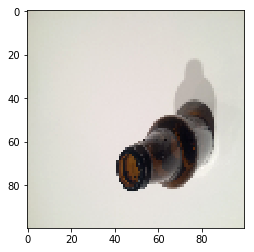

In [44]:
img = keras.applications.xception.preprocess_input(X[0])
plt.imshow(keras.preprocessing.image.array_to_img(img))
plt.show()